<a href="https://colab.research.google.com/github/psyduck1203/Hands-on-ML-Basic-to-Advance-/blob/master/Bitcoin%20Price%20Predictor/Bitcoin_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow pandas numpy matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\GauravKarakoti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [5]:
plt.style.use('ggplot')
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data.sort_values('Date', inplace=True)
    return data

In [7]:
def add_technical_indicators(df):
    # Simple Moving Average
    df['SMA_7'] = df['Close'].rolling(window=7).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    
    # Relative Strength Index
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Moving Average Convergence Divergence
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    sma20 = df['Close'].rolling(window=20).mean()
    std20 = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma20 + (2 * std20)
    df['Bollinger_Lower'] = sma20 - (2 * std20)
    
    # Drop NaN values
    df.dropna(inplace=True)
    return df

In [8]:
def create_sequences(data, seq_length, target_col_idx='Open'):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, target_col_idx])
    return np.array(X), np.array(y)

Epoch 1/100


C:\Users\GauravKarakoti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 0.0226 - val_loss: 0.0046
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0024 - val_loss: 9.6651e-04
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0021 - val_loss: 9.8517e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0021 - val_loss: 8.9387e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0016 - val_loss: 7.2718e-04
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━

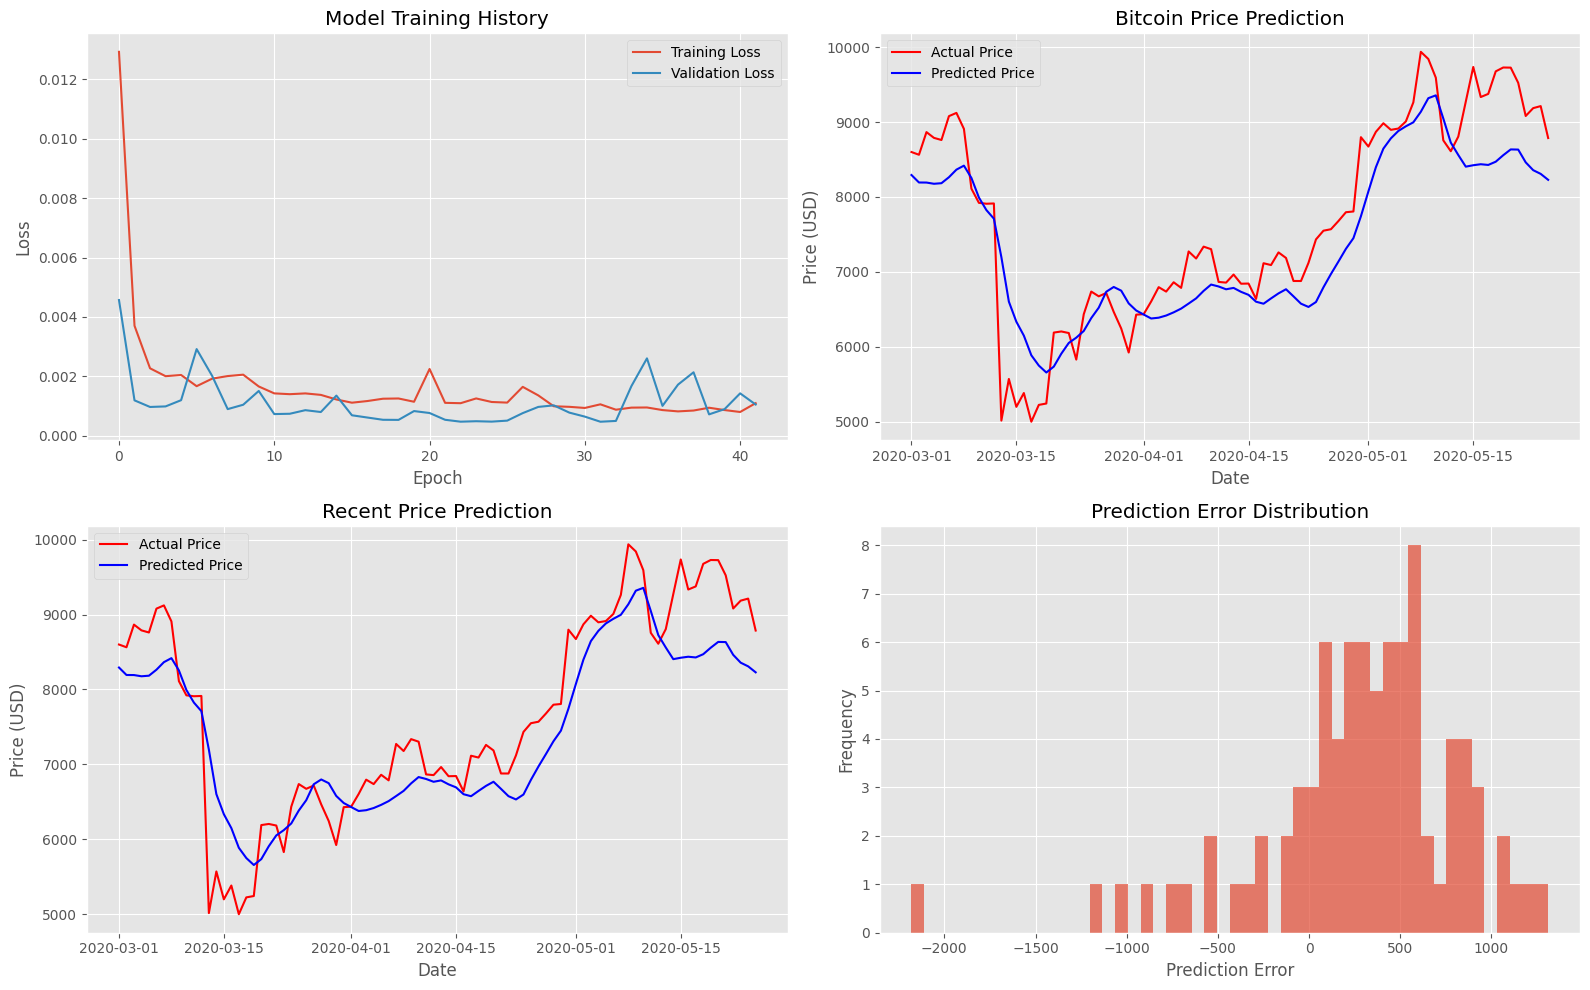


Model Evaluation Metrics
Metric            Training Set       Test Set
MSE                  217392.55      385393.07
MAE                     332.46         501.23
RMSE                    466.25         620.80
MAPE (%)                 26.88           6.72


In [10]:
if __name__ == "__main__":
    # Load and prepare data
    data = load_data('BTC-USD.csv')
    data = add_technical_indicators(data)
    
    # Select features and target
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'SMA_7', 'SMA_30', 'RSI', 'MACD', 
                'Signal_Line', 'Bollinger_Upper', 'Bollinger_Lower']
    target = 'Open'
    
    feature_data = data[features].values
    target_idx = features.index(target)
    
    # Split data (chronological split)
    split_date = '2020-01-01'
    train = data[data['Date'] < split_date]
    test = data[data['Date'] >= split_date]
    
    # Scale features
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train[features])
    test_scaled = scaler.transform(test[features])
    
    # Create sequences
    SEQ_LENGTH = 60
    X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH, target_idx)
    X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH, target_idx)

    test_dates = test['Date'].values[SEQ_LENGTH:]
    
    # Split into train/validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Build LSTM model
    def build_lstm_model(input_shape):
        model = Sequential([
            Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)),
            Dropout(0.3),
            Bidirectional(LSTM(64, return_sequences=True)),
            Dropout(0.3),
            Bidirectional(LSTM(32)),
            Dropout(0.3),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
    
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True)
    ]
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    model = tf.keras.models.load_model('best_model.keras')
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Inverse scaling
    def inverse_scale(data, predictions, target_idx):
        dummy = np.zeros((len(predictions), len(features)))
        dummy[:, target_idx] = predictions.flatten()
        return scaler.inverse_transform(dummy)[:, target_idx]
    
    y_train_orig = inverse_scale(train_scaled, y_train, target_idx)
    train_pred_orig = inverse_scale(train_scaled, train_pred, target_idx)
    y_test_orig = inverse_scale(test_scaled, y_test, target_idx)
    test_pred_orig = inverse_scale(test_scaled, test_pred, target_idx)
    
    # Calculate metrics
    def calculate_metrics(actual, predicted):
        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        return mse, mae, rmse, mape
    
    train_metrics = calculate_metrics(y_train_orig, train_pred_orig)
    test_metrics = calculate_metrics(y_test_orig, test_pred_orig)
    
    # Plot results
    plt.figure(figsize=(16, 10))
    
    # Training history
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(test_dates, y_test_orig, 'r-', label='Actual Price')
    plt.plot(test_dates, test_pred_orig, 'b-', label='Predicted Price')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    zoom_range = min(100, len(test_dates))  # Ensure we don't exceed array length
    plt.plot(test_dates[-zoom_range:], y_test_orig[-zoom_range:], 'r-', label='Actual Price')
    plt.plot(test_dates[-zoom_range:], test_pred_orig[-zoom_range:], 'b-', label='Predicted Price')
    plt.title('Recent Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    
    # Error distribution
    plt.subplot(2, 2, 4)
    errors = y_test_orig - test_pred_orig
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('prediction_results.png', dpi=300)
    plt.show()
    
    # Print metrics
    print("\n" + "="*60)
    print("Model Evaluation Metrics")
    print("="*60)
    print(f"{'Metric':<15}{'Training Set':>15}{'Test Set':>15}")
    print(f"{'MSE':<15}{train_metrics[0]:>15.2f}{test_metrics[0]:>15.2f}")
    print(f"{'MAE':<15}{train_metrics[1]:>15.2f}{test_metrics[1]:>15.2f}")
    print(f"{'RMSE':<15}{train_metrics[2]:>15.2f}{test_metrics[2]:>15.2f}")
    print(f"{'MAPE (%)':<15}{train_metrics[3]:>15.2f}{test_metrics[3]:>15.2f}")
    print("="*60)